<a href="https://colab.research.google.com/github/sen-com/colaboratory/blob/main/GAN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**編集中**
# 事例研究08回


| 回次   | 曜日     | 内容               |
| ------ | -------- | ------------------ |
| 第2回  | 10月20日(火)5限 | 上級生研究内容発表(1/2) |
| 第3回  | 10月27日(火)5限 | 上級生研究内容発表(2/2) |
| 第4回  | 11月3日(火) 5限 | Deepラーニングは怖くない(CIFIR10編)|
| 第5回  | 11月10日(火)5限 | Deepラーニングは怖くない(CIFIR10編)2|
| --    | 11月17日(火) | 試験期間               |
| 第6回  | 11月24日(火)5限 | Alexさんによる人の声を対象にしたWave-net                    |
| 第7回  | 12月1日(火) 5限 | 竹田さんによる楽器音を対象にしたWave-net                   |
| **第8回**  | **12月8日(火) 5限**| **佐藤+上松によるDCGANは怖くない**|
| 第9回  | 12月15日(火) 5限| 選択課題提示　   |
| 第10回 | 12月22日(火) 5限| 各自選んだテーマの発表        |
| 休み | *20日間の休み* |                    |
| 第11回 | 1月12日(火)  5限| 進捗報告①                  |
| 第12回 | 1月19日(火)  5限| 進捗報告②      |

## 今後の流れ

第9回では先輩方がいろいろ動きそうなプログラムを調べてくれます\
それを皆さんが自身で選び動かすことになります

<動かすために>\
今日は最後に宿題を出します。

来週のプログラムを動かす時にも使うだけではなく、\
今後の研究を行う上で必要な力になりますので頑張ってみてください

参考サイト : [PyTorchでCIFAR-10を基にDCGANで画像生成をしてみよう ](https://www.atmarkit.co.jp/ait/articles/2011/27/news024.html)

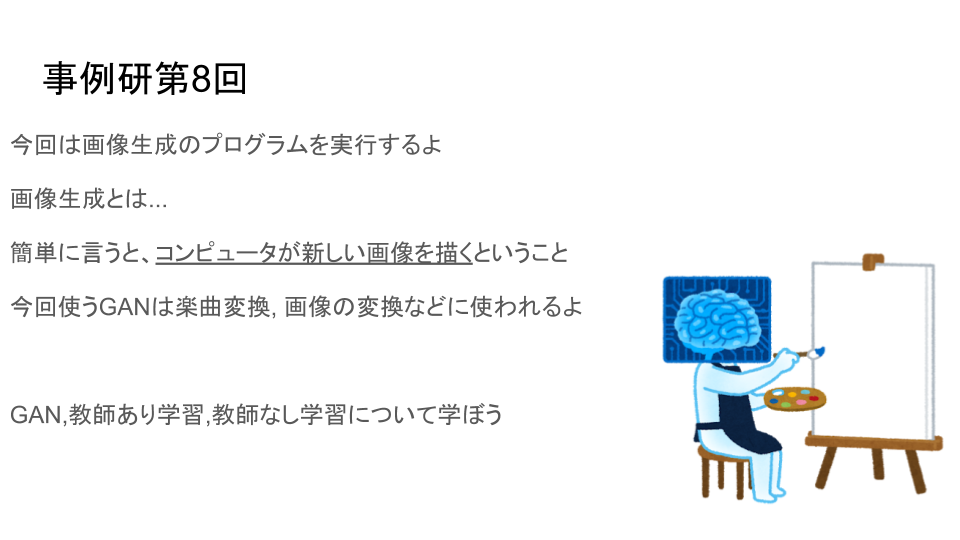

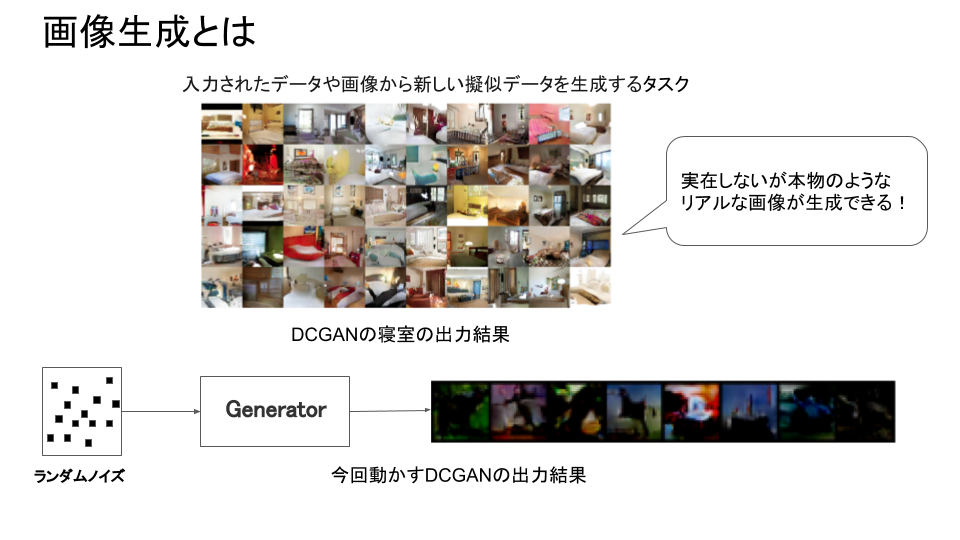

In [2]:
!nvidia-smi

Mon Dec 14 16:06:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### ライブラリインポート

In [3]:
#このセルはライブラリ(pytorch(機械学習ライブラリ),matplotlib(画像出力用),numpy(行列計算) )のimportをしている(佐藤コメント)
import torch
from torch import optim
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#このセルではdatasetのダウンロード(佐藤メモ)
'''
https://qiita.com/kazetof/items/6a72926b9f8cd44c218e
transformはデータの下処理(テンソルに変換)してtorchの型になるように処理をしている
（佐藤メモ）
Normalizeを変更してあげると、画像の処理が変わり画像の印象が変わるよ
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 100
trainset = CIFAR10('.', train=True, transform=transform, download=True)#trainデータをダウンロードしている(佐藤メモ)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)#trainデータをシャッフルしてbatch_sizeに切り分けたデータにする(佐藤メモ)

Files already downloaded and verified


In [5]:
# 学習中に生成された画像の表示、保存する関数
# 引数にepochを追加し、画像を上書きしないように変更した
def imshow(img, epoch):
    img = torchvision.utils.make_grid(img)
    npimg = img.detach().numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    
    #下のコメントアウトされている1行で画像を保存できるよ(毎度上書き保存になるから気を付けて)
    # epoch番号で保存
    plt.savefig(f'{epoch}.jpg')
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 32, 32])


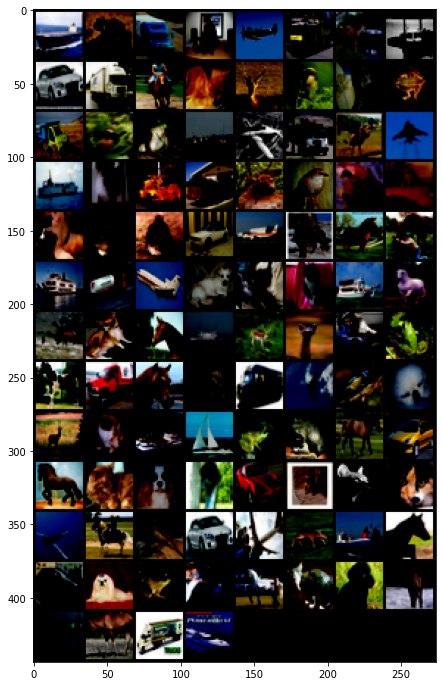

In [6]:
# 学習データをイテレータに変換
iterator = iter(trainloader)
img, _ = next(iterator)
print(img.shape)
imshow(img[0:100],1)

In [7]:
class MakeFrom(nn.Module):
    def __init__(self, s):
        super().__init__()
        self.model = s
    def forward(self, x):
        return self.model(x)

### 主要なモジュールの定義

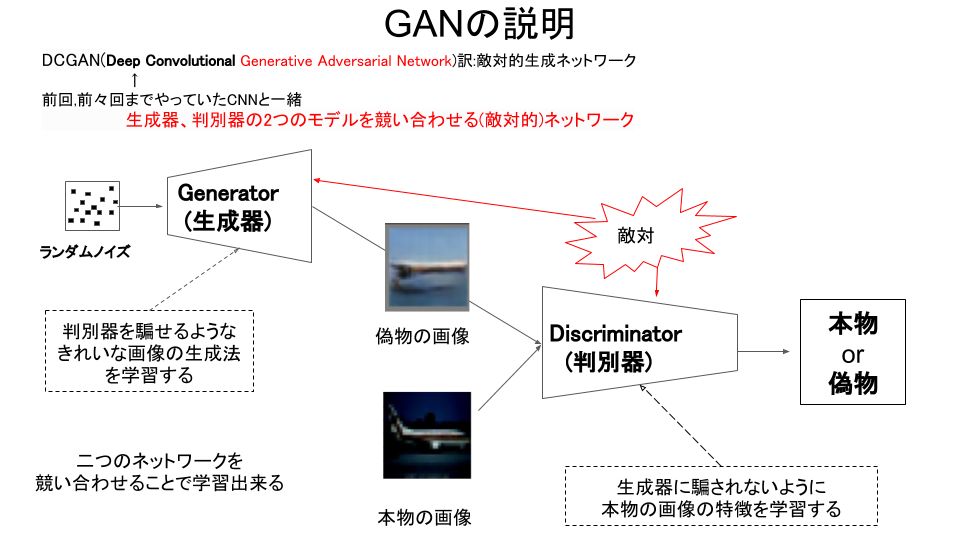

In [8]:
def train(netD, netG, batch_size, zsize, epochs, trainloader):
    losses_netD = []
    losses_netG = []
    out_D_real = []
    out_D_fake = []
    out_G = []

    # GPUを使用する準備
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    netD = netD.to(device)
    netG = netG.to(device)
    one_labels = torch.ones(batch_size).reshape(batch_size, 1).to(device)
    zero_labels = torch.zeros(batch_size).reshape(batch_size, 1).to(device)
    criterion = nn.BCELoss().to(device)

    optD = optim.Adam(netD.parameters(), lr=0.0002, betas=[0.5, 0.999])
    optG = optim.Adam(netG.parameters(), lr=0.0002, betas=[0.5, 0.999])

    # ノイズを固定
    fixed_noise = torch.randn(100, zsize, 1, 1).to(device)
    
    for epoch in range(1, epochs+1):
        running_loss_netD = 0.0
        running_loss_netG = 0.0
        for count, (real_imgs, _) in enumerate(trainloader, 1):
            netD.zero_grad()

            # 識別器の学習
            real_imgs = real_imgs.to(device)
            # データローダーから読み込んだデータを識別器に入力し、損失を計算
            output_real = netD(real_imgs).reshape(batch_size, -1)
            loss_real = criterion(output_real, one_labels)
            
            loss_real.backward()

            # 生成器から得たデータを、識別器に入力し、損失を計算
            z = torch.randn(batch_size, zsize, 1, 1).to(device)
            fake_imgs = netG(z).to(device)
            output_fake1 = netD(fake_imgs.detach()).reshape(batch_size, -1)
            loss_fake1 = criterion(output_fake1, zero_labels)
            loss_fake1.backward()

            # それらをまとめたものが最終的な損失
            loss_netD = loss_real + loss_fake1
            optD.step()
            running_loss_netD += loss_netD  # 1バッチ分の損失の平均値を加算

            # 生成器の学習
            netG.zero_grad()
            z = torch.randn(batch_size, zsize, 1, 1).to(device)
            fake_imgs = netG(z).to(device)
            output_fake2 = netD(fake_imgs).reshape(batch_size, -1)
            loss_netG = criterion(output_fake2, one_labels)
            loss_netG.backward()
            optG.step()
            running_loss_netG += loss_netG # 1バッチ分の損失の平均値を加算

            if epoch == 1:  # 最初のエポックだけ10、20、……、100バッチ終了時の学習状況を表示
                if count < 100 and count % 10 ==0:
                    stat1 = f'epoch: {epoch:02d}, batch: {count}\t'
                    stat2 = f'  lossD: {loss_netD:.4f}(real: {loss_real:.4f}, fake: {loss_fake1:.4f}),'
                    stat3 = f'lossG: {loss_netG:.4f},  D(x): {output_real.mean():.4f},'
                    stat4 = f'D(G(z)): {output_fake1.mean():.4f}, {output_fake2.mean():.4f}'
                    print(stat1, stat2, stat3, stat4)

            if count % 100 == 0:  # 1エポックの中で100回ごとに学習の状況を記録
                out_D_real.append(output_real.mean())
                out_D_fake.append(output_fake1.mean())
                out_G.append(output_fake2.mean())
                stat1 = f'epoch: {epoch:02d}, batch: {count}\t'
                stat2 = f'  lossD: {loss_netD:.4f}(real: {loss_real:.4f}, fake: {loss_fake1:.4f}),'
                stat3 = f'lossG: {loss_netG:.4f},  D(x): {output_real.mean():.4f},'
                stat4 = f'D(G(z)): {output_fake1.mean():.4f}, {output_fake2.mean():.4f}'
                print(stat1, stat2, stat3, stat4)
            
            

        running_loss_netD /= count  # 1エポック終了時にその間の損失の平均を求める
        running_loss_netG /= count
        losses_netD.append(running_loss_netD)
        losses_netG.append(running_loss_netG)
        print(f'epoch: {epoch}, running_loss_D: {running_loss_netD}, running_loss_G: {running_loss_netG}', '\n')

        # 20エポックごとに画像を生成
        if epoch % 20 == 0:
          generated_imgs = netG(fixed_noise[0:8]).cpu()
          imshow(generated_imgs.reshape(8, 3, 32, 32), epoch)
        
        if epoch % 50 == 0:
          plt.figure(figsize=(10,5))
          plt.title('losses')
          plt.plot(losses_netD, label='netD')
          plt.plot(losses_netG, label='netG')
          plt.xlabel('epoch')
          plt.ylabel('loss')
          plt.legend()
          plt.savefig(f'{epoch}_losses.jpg')
          plt.show()

          plt.figure(figsize=(10,5))
          plt.title('output from discriminator')
          plt.plot(out_D_real, label='D(x)')
          plt.plot(out_D_fake, label='D(G(z)) #1')
          plt.plot(out_G, label='D(G(z)) #2')
          plt.xlabel('x 100 batches')
          plt.ylabel('output')
          plt.legend()
          plt.savefig(f'{epoch}_output.jpg')
          plt.show()

    generated_imgs = netG(fixed_noise).cpu()
    imshow(generated_imgs.reshape(100, 3, 32, 32), 1821035)

    return (losses_netD, losses_netG), (out_D_real, out_D_fake, out_G), (netD, netG)

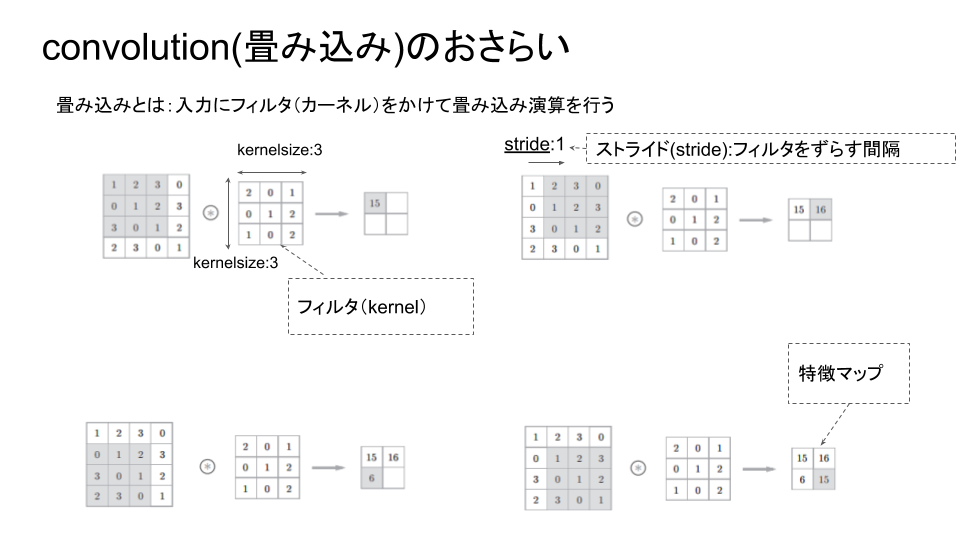

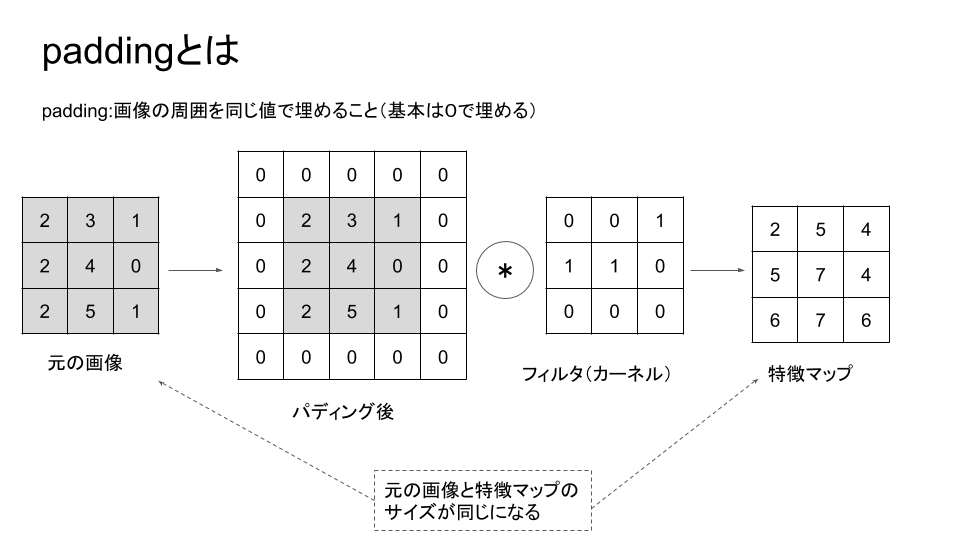

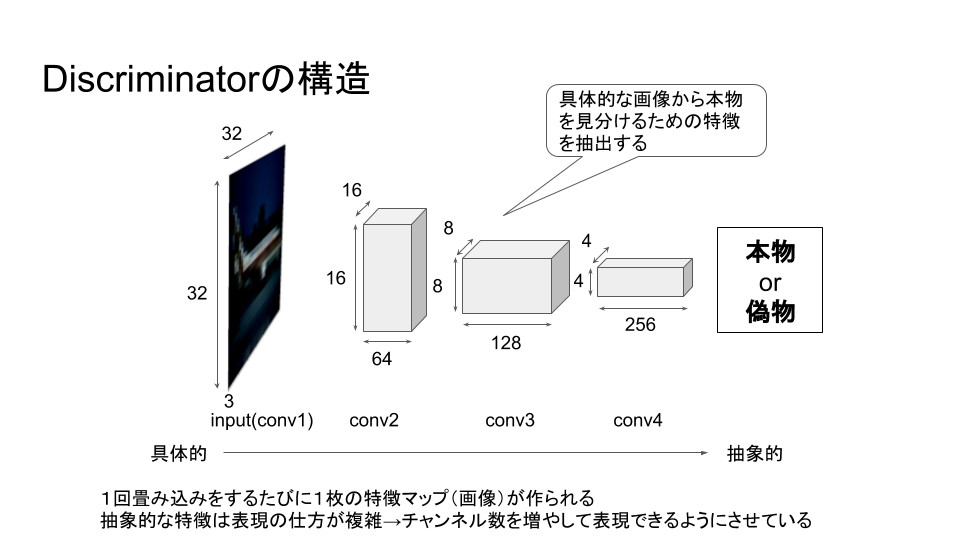

In [9]:
# 重みの初期値を変更する関数
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
# バッチ正規化を追加
discriminator = nn.Sequential(
    
    nn.Conv2d(3, 64, 4, 2, 1, bias=False), #input
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, 4, 2, 1, bias=False), #conv2
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, 4, 2, 1, bias=False), #conv3
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 1, 4, 1, 0, bias=False), #conv4
    nn.Sigmoid()
)

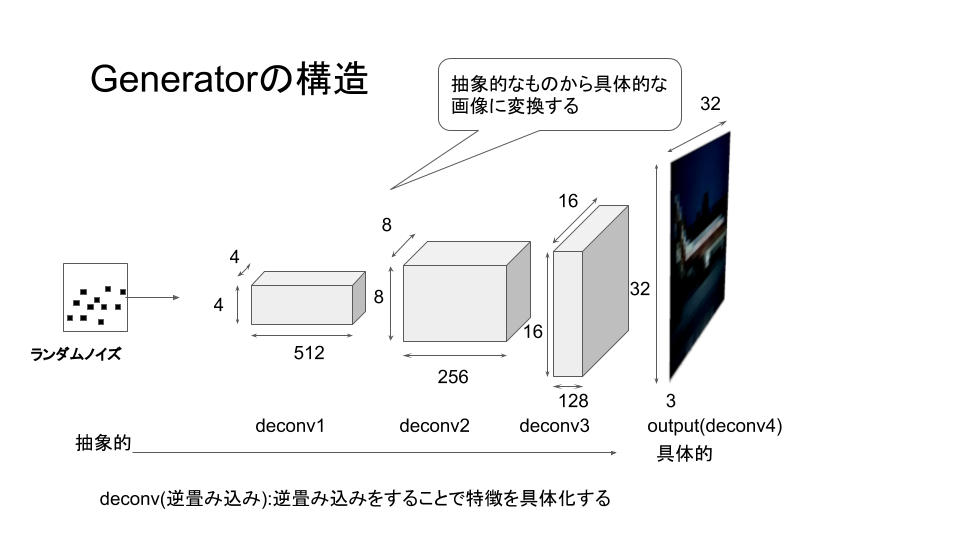

In [11]:
# バッチ正規化を追加
feature_maps = 64
zsize = 100
generator = nn.Sequential(
    nn.ConvTranspose2d(zsize, feature_maps * 8, 4, 1, 0, bias=False), #deconv1
    nn.BatchNorm2d(feature_maps * 8),
    nn.ReLU(inplace=True),

    nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False), #deconv2
    nn.BatchNorm2d(feature_maps * 4),
    nn.ReLU(inplace=True),

    nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False), #deconv3
    nn.BatchNorm2d(feature_maps * 2),
    nn.ReLU(inplace=True),

    nn.ConvTranspose2d(feature_maps * 2, 3, 4, 2, 1, bias=False), #output
    nn.Tanh()
)

netD = MakeFrom(discriminator)
netG = MakeFrom(generator)

# 重みの平均を0、標準偏差を0.02に初期化
netD.apply(weights_init)
netG.apply(weights_init)

MakeFrom(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [12]:
iterator = iter(trainloader)
img, _ = next(iterator)

c1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
c2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
c3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
c4 = nn.Conv2d(256, 1, 4, 1, 0, bias=False)
b2 = nn.BatchNorm2d(128)
b3 = nn.BatchNorm2d(256)
relu = nn.LeakyReLU(0.2, inplace=True)
sigmoid = nn.Sigmoid()

x = relu(c1(img))
print(x.shape)
x = relu(b2(c2(x)))
print(x.shape)
x = relu(b3(c3(x)))
print(x.shape)
x = sigmoid(c4(x))
print(x.shape)

print('----')

zsize = 100
t1 = nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False)
bt1 = nn.BatchNorm2d(64 * 8)
t2 = nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False)
bt2 = nn.BatchNorm2d(64 * 4)
t3 = nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False)
bt3 = nn.BatchNorm2d(64 * 2)
t4 = nn.ConvTranspose2d(64 * 2, 3, 4, 2, 1, bias=False)
tanh = nn.Tanh()

z = torch.randn(batch_size, zsize, 1, 1)
x = relu(bt1(t1(z)))
print(x.shape)
x = relu(bt2(t2(x)))
print(x.shape)
x = relu(bt3(t3(x)))
print(x.shape)
x = tanh(t4(x))
print(x.shape)

torch.Size([100, 64, 16, 16])
torch.Size([100, 128, 8, 8])
torch.Size([100, 256, 4, 4])
torch.Size([100, 1, 1, 1])
----
torch.Size([100, 512, 4, 4])
torch.Size([100, 256, 8, 8])
torch.Size([100, 128, 16, 16])
torch.Size([100, 3, 32, 32])


### GANの学習について

lossD:本物の画像を入れたときにどれくらい差があるか , 偽物の画像を入れたときにどれくらいの差があるか\
\
lossG:生成された画像が本物の画像とどれくらい差があるか\
\
D(x):discriminatorが本物と見抜いた割合（精度）\
\
D(G(z)):gen画像を入れたときの見抜いた割合、または騙された割合


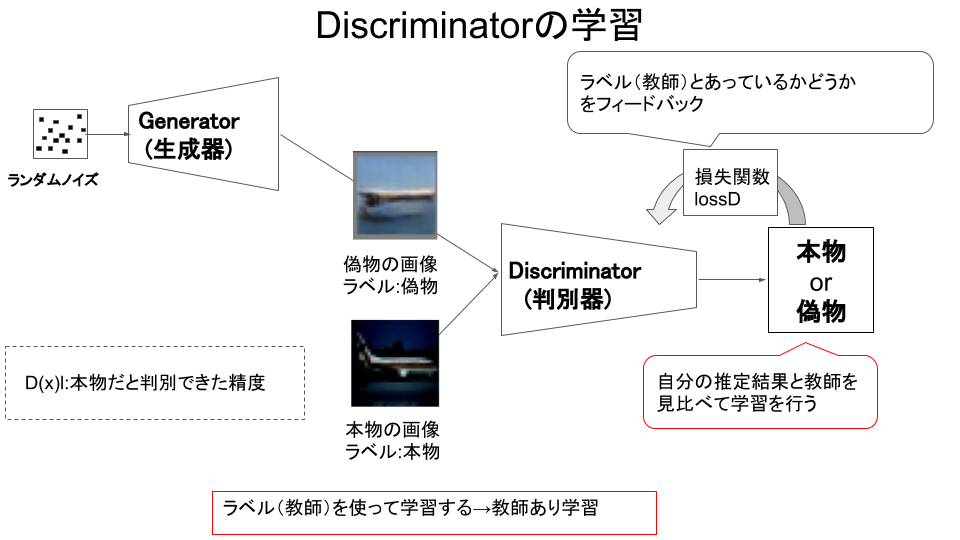

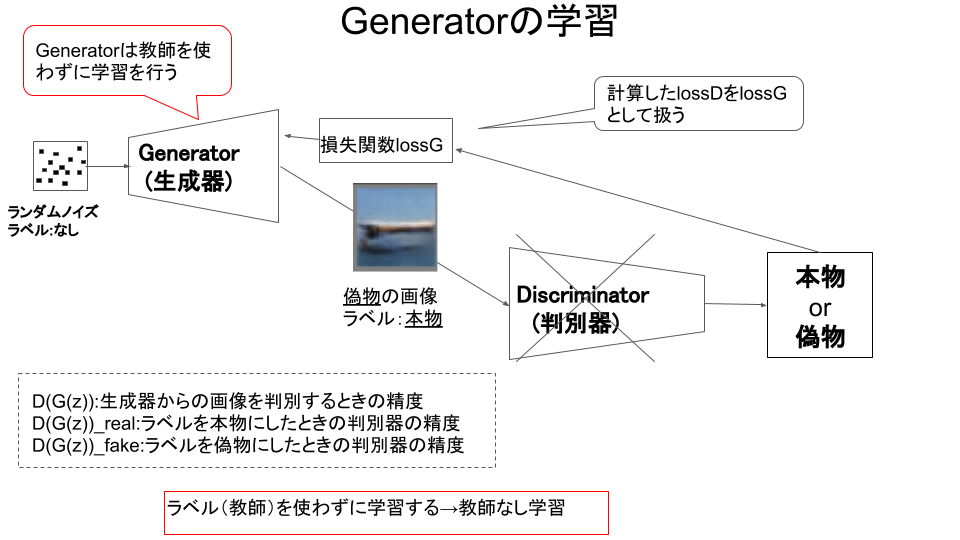

epoch: 01, batch: 10	   lossD: 1.3192(real: 0.6143, fake: 0.7049), lossG: 0.6946,  D(x): 0.5413, D(G(z)): 0.5058, 0.4993
epoch: 01, batch: 20	   lossD: 1.1600(real: 0.5210, fake: 0.6389), lossG: 0.7905,  D(x): 0.5947, D(G(z)): 0.4721, 0.4536
epoch: 01, batch: 30	   lossD: 0.8604(real: 0.3798, fake: 0.4805), lossG: 1.0192,  D(x): 0.6846, D(G(z)): 0.3815, 0.3609
epoch: 01, batch: 40	   lossD: 0.5948(real: 0.2640, fake: 0.3308), lossG: 1.3330,  D(x): 0.7685, D(G(z)): 0.2817, 0.2637
epoch: 01, batch: 50	   lossD: 0.4308(real: 0.1966, fake: 0.2342), lossG: 1.6459,  D(x): 0.8221, D(G(z)): 0.2088, 0.1928
epoch: 01, batch: 60	   lossD: 0.3049(real: 0.1362, fake: 0.1686), lossG: 1.9604,  D(x): 0.8729, D(G(z)): 0.1551, 0.1408
epoch: 01, batch: 70	   lossD: 0.4142(real: 0.2025, fake: 0.2117), lossG: 2.0273,  D(x): 0.8207, D(G(z)): 0.1855, 0.1389
epoch: 01, batch: 80	   lossD: 0.1963(real: 0.0826, fake: 0.1138), lossG: 2.4237,  D(x): 0.9210, D(G(z)): 0.1075, 0.0888
epoch: 01, batch: 90	   lossD: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 20, batch: 500	   lossD: 1.1261(real: 0.8012, fake: 0.3250), lossG: 0.8791,  D(x): 0.4913, D(G(z)): 0.2643, 0.4518
epoch: 20, running_loss_D: 0.966949999332428, running_loss_G: 1.4044297933578491 



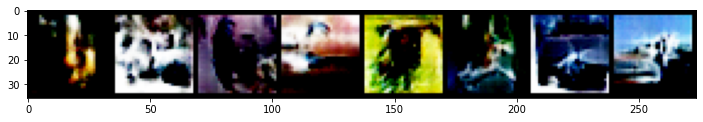

epoch: 21, batch: 100	   lossD: 0.9795(real: 0.7627, fake: 0.2168), lossG: 0.8180,  D(x): 0.4959, D(G(z)): 0.1884, 0.4812
epoch: 21, batch: 200	   lossD: 0.8708(real: 0.5959, fake: 0.2749), lossG: 0.9416,  D(x): 0.5794, D(G(z)): 0.2294, 0.4279
epoch: 21, batch: 300	   lossD: 0.9786(real: 0.2956, fake: 0.6830), lossG: 1.8819,  D(x): 0.7569, D(G(z)): 0.4649, 0.1829
epoch: 21, batch: 400	   lossD: 1.0171(real: 0.2324, fake: 0.7847), lossG: 1.8877,  D(x): 0.8027, D(G(z)): 0.5174, 0.1786
epoch: 21, batch: 500	   lossD: 0.9356(real: 0.1459, fake: 0.7897), lossG: 2.1453,  D(x): 0.8678, D(G(z)): 0.5174, 0.1350
epoch: 21, running_loss_D: 0.9576320648193359, running_loss_G: 1.4105671644210815 

epoch: 22, batch: 100	   lossD: 1.0086(real: 0.6286, fake: 0.3801), lossG: 1.3710,  D(x): 0.5636, D(G(z)): 0.3001, 0.2820
epoch: 22, batch: 200	   lossD: 0.9979(real: 0.7093, fake: 0.2886), lossG: 1.1442,  D(x): 0.5218, D(G(z)): 0.2399, 0.3536
epoch: 22, batch: 300	   lossD: 0.7420(real: 0.2346, fake: 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 40, batch: 500	   lossD: 0.7311(real: 0.1167, fake: 0.6144), lossG: 1.8282,  D(x): 0.8960, D(G(z)): 0.4179, 0.2079
epoch: 40, running_loss_D: 0.7892225384712219, running_loss_G: 1.684954047203064 



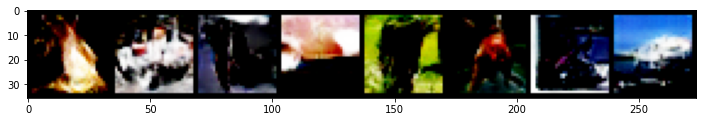

epoch: 41, batch: 100	   lossD: 0.7810(real: 0.1298, fake: 0.6511), lossG: 2.2145,  D(x): 0.8817, D(G(z)): 0.4407, 0.1360
epoch: 41, batch: 200	   lossD: 0.7774(real: 0.2041, fake: 0.5734), lossG: 2.5464,  D(x): 0.8269, D(G(z)): 0.4054, 0.1075
epoch: 41, batch: 300	   lossD: 0.6662(real: 0.3605, fake: 0.3057), lossG: 1.8876,  D(x): 0.7219, D(G(z)): 0.2435, 0.1978
epoch: 41, batch: 400	   lossD: 0.7803(real: 0.1496, fake: 0.6307), lossG: 2.1028,  D(x): 0.8666, D(G(z)): 0.4361, 0.1471
epoch: 41, batch: 500	   lossD: 0.8381(real: 0.2550, fake: 0.5831), lossG: 1.9758,  D(x): 0.7907, D(G(z)): 0.3938, 0.1720
epoch: 41, running_loss_D: 0.7560130953788757, running_loss_G: 1.708488941192627 

epoch: 42, batch: 100	   lossD: 0.7435(real: 0.5916, fake: 0.1519), lossG: 1.2116,  D(x): 0.5802, D(G(z)): 0.1363, 0.3460
epoch: 42, batch: 200	   lossD: 0.7223(real: 0.4922, fake: 0.2301), lossG: 1.5091,  D(x): 0.6381, D(G(z)): 0.1937, 0.2669
epoch: 42, batch: 300	   lossD: 0.7807(real: 0.5792, fake: 0.20

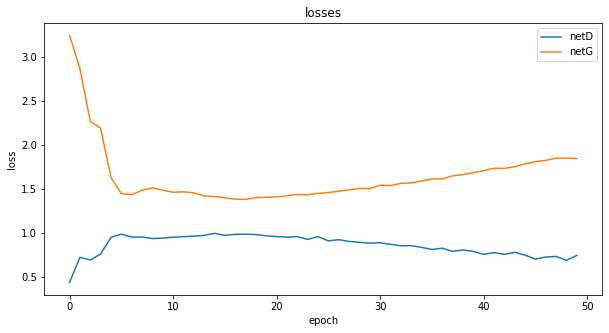

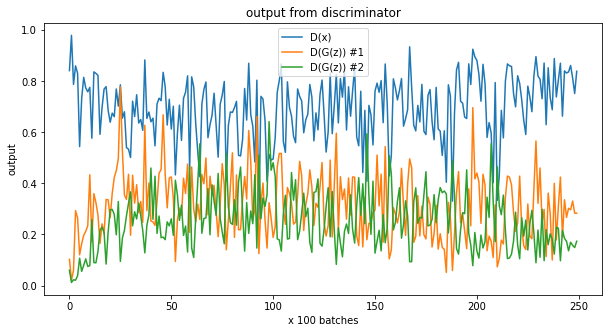

epoch: 51, batch: 100	   lossD: 0.5250(real: 0.1737, fake: 0.3514), lossG: 2.5743,  D(x): 0.8506, D(G(z)): 0.2751, 0.1055
epoch: 51, batch: 200	   lossD: 0.6364(real: 0.2876, fake: 0.3489), lossG: 1.6394,  D(x): 0.7653, D(G(z)): 0.2728, 0.2534
epoch: 51, batch: 300	   lossD: 0.8483(real: 0.1776, fake: 0.6708), lossG: 2.6203,  D(x): 0.8453, D(G(z)): 0.4574, 0.1099
epoch: 51, batch: 400	   lossD: 0.5442(real: 0.4062, fake: 0.1381), lossG: 1.8441,  D(x): 0.6930, D(G(z)): 0.1199, 0.2193
epoch: 51, batch: 500	   lossD: 0.6305(real: 0.3996, fake: 0.2309), lossG: 1.4889,  D(x): 0.6976, D(G(z)): 0.1929, 0.2768
epoch: 51, running_loss_D: 0.6836997270584106, running_loss_G: 1.8760054111480713 

epoch: 52, batch: 100	   lossD: 3.0724(real: 0.0106, fake: 3.0618), lossG: 4.6863,  D(x): 0.9895, D(G(z)): 0.9246, 0.0245
epoch: 52, batch: 200	   lossD: 0.7122(real: 0.6410, fake: 0.0711), lossG: 1.4207,  D(x): 0.5666, D(G(z)): 0.0672, 0.3133
epoch: 52, batch: 300	   lossD: 0.6927(real: 0.3058, fake: 0.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 60, batch: 500	   lossD: 0.5175(real: 0.3776, fake: 0.1399), lossG: 1.8018,  D(x): 0.7131, D(G(z)): 0.1249, 0.2142
epoch: 60, running_loss_D: 0.622952401638031, running_loss_G: 2.0471365451812744 



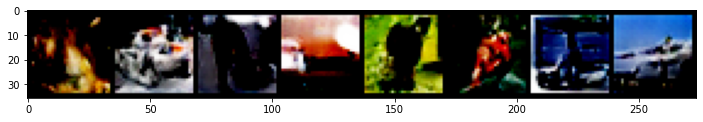

epoch: 61, batch: 100	   lossD: 0.3980(real: 0.2064, fake: 0.1916), lossG: 1.7090,  D(x): 0.8274, D(G(z)): 0.1648, 0.2434
epoch: 61, batch: 200	   lossD: 0.5429(real: 0.2574, fake: 0.2855), lossG: 2.0540,  D(x): 0.7917, D(G(z)): 0.2260, 0.1872
epoch: 61, batch: 300	   lossD: 0.5542(real: 0.4371, fake: 0.1170), lossG: 1.5242,  D(x): 0.6760, D(G(z)): 0.1044, 0.2682
epoch: 61, batch: 400	   lossD: 0.5768(real: 0.1163, fake: 0.4606), lossG: 3.2028,  D(x): 0.8946, D(G(z)): 0.3260, 0.0611
epoch: 61, batch: 500	   lossD: 0.6965(real: 0.5408, fake: 0.1556), lossG: 1.2891,  D(x): 0.6232, D(G(z)): 0.1341, 0.3376
epoch: 61, running_loss_D: 0.6217451691627502, running_loss_G: 2.1012942790985107 

epoch: 62, batch: 100	   lossD: 0.6137(real: 0.1624, fake: 0.4513), lossG: 2.4940,  D(x): 0.8582, D(G(z)): 0.3289, 0.1259
epoch: 62, batch: 200	   lossD: 0.5888(real: 0.3251, fake: 0.2637), lossG: 1.8315,  D(x): 0.7462, D(G(z)): 0.2098, 0.2152
epoch: 62, batch: 300	   lossD: 0.5852(real: 0.2303, fake: 0.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 80, batch: 500	   lossD: 0.5719(real: 0.1335, fake: 0.4385), lossG: 3.1249,  D(x): 0.8817, D(G(z)): 0.3105, 0.0816
epoch: 80, running_loss_D: 0.49960362911224365, running_loss_G: 2.401463508605957 



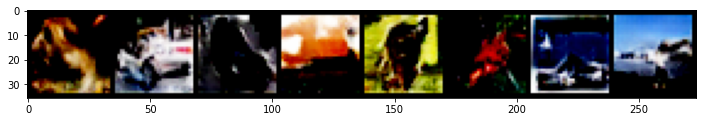

epoch: 81, batch: 100	   lossD: 0.6007(real: 0.4235, fake: 0.1772), lossG: 1.4183,  D(x): 0.6862, D(G(z)): 0.1534, 0.3166
epoch: 81, batch: 200	   lossD: 0.3336(real: 0.1987, fake: 0.1349), lossG: 1.4591,  D(x): 0.8405, D(G(z)): 0.1199, 0.3090
epoch: 81, batch: 300	   lossD: 0.3937(real: 0.2105, fake: 0.1832), lossG: 2.3779,  D(x): 0.8266, D(G(z)): 0.1558, 0.1327
epoch: 81, batch: 400	   lossD: 0.4744(real: 0.4021, fake: 0.0723), lossG: 1.8550,  D(x): 0.7029, D(G(z)): 0.0667, 0.2349
epoch: 81, batch: 500	   lossD: 0.4482(real: 0.0775, fake: 0.3707), lossG: 2.3250,  D(x): 0.9288, D(G(z)): 0.2747, 0.1502
epoch: 81, running_loss_D: 0.5041762590408325, running_loss_G: 2.3975024223327637 

epoch: 82, batch: 100	   lossD: 0.3846(real: 0.1752, fake: 0.2095), lossG: 2.7363,  D(x): 0.8470, D(G(z)): 0.1701, 0.1098
epoch: 82, batch: 200	   lossD: 0.3576(real: 0.2336, fake: 0.1241), lossG: 1.5984,  D(x): 0.8059, D(G(z)): 0.0928, 0.2827
epoch: 82, batch: 300	   lossD: 0.3493(real: 0.1088, fake: 0.2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 100, batch: 500	   lossD: 0.2926(real: 0.1629, fake: 0.1297), lossG: 2.5087,  D(x): 0.8582, D(G(z)): 0.1146, 0.1386
epoch: 100, running_loss_D: 0.4241553246974945, running_loss_G: 2.6795921325683594 



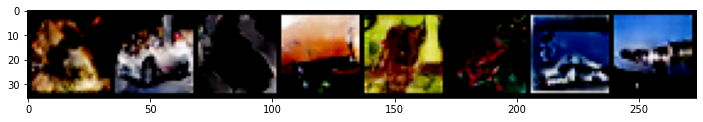

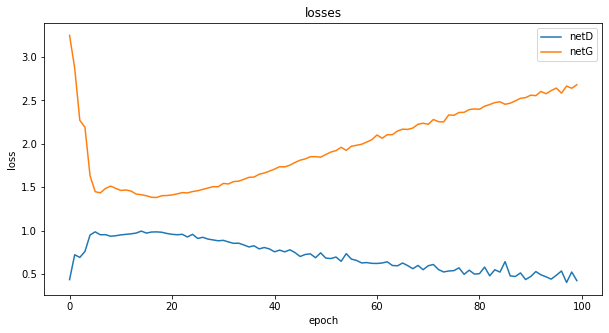

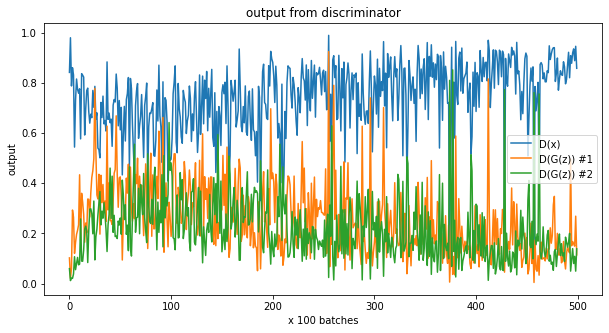

epoch: 101, batch: 100	   lossD: 0.2148(real: 0.1263, fake: 0.0884), lossG: 2.2362,  D(x): 0.8866, D(G(z)): 0.0743, 0.1831
epoch: 101, batch: 200	   lossD: 0.5084(real: 0.1593, fake: 0.3490), lossG: 3.1349,  D(x): 0.8710, D(G(z)): 0.2506, 0.0847
epoch: 101, batch: 300	   lossD: 0.4495(real: 0.0237, fake: 0.4258), lossG: 3.7692,  D(x): 0.9770, D(G(z)): 0.3099, 0.0420
epoch: 101, batch: 400	   lossD: 0.4558(real: 0.4266, fake: 0.0292), lossG: 2.9046,  D(x): 0.6886, D(G(z)): 0.0282, 0.0993
epoch: 101, batch: 500	   lossD: 0.3317(real: 0.1738, fake: 0.1579), lossG: 2.4370,  D(x): 0.8527, D(G(z)): 0.1301, 0.1416
epoch: 101, running_loss_D: 0.502650797367096, running_loss_G: 2.6887574195861816 

epoch: 102, batch: 100	   lossD: 0.2858(real: 0.1008, fake: 0.1850), lossG: 2.4498,  D(x): 0.9091, D(G(z)): 0.1518, 0.1694
epoch: 102, batch: 200	   lossD: 0.2393(real: 0.0828, fake: 0.1565), lossG: 3.0743,  D(x): 0.9234, D(G(z)): 0.1358, 0.0808
epoch: 102, batch: 300	   lossD: 0.1505(real: 0.0534, f

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 120, batch: 500	   lossD: 0.4521(real: 0.1679, fake: 0.2842), lossG: 2.9196,  D(x): 0.8580, D(G(z)): 0.2019, 0.1077
epoch: 120, running_loss_D: 0.4925166368484497, running_loss_G: 2.888967275619507 



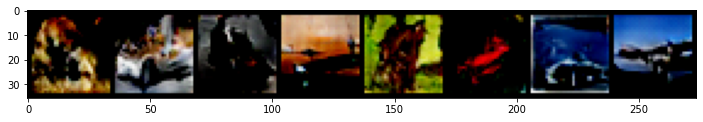

epoch: 121, batch: 100	   lossD: 0.3152(real: 0.0459, fake: 0.2693), lossG: 3.7368,  D(x): 0.9565, D(G(z)): 0.2055, 0.0529
epoch: 121, batch: 200	   lossD: 0.2329(real: 0.1226, fake: 0.1104), lossG: 2.9028,  D(x): 0.8912, D(G(z)): 0.0991, 0.1295
epoch: 121, batch: 300	   lossD: 0.3124(real: 0.1133, fake: 0.1991), lossG: 2.2832,  D(x): 0.8996, D(G(z)): 0.1613, 0.1779
epoch: 121, batch: 400	   lossD: 0.3403(real: 0.0244, fake: 0.3159), lossG: 3.6769,  D(x): 0.9762, D(G(z)): 0.2324, 0.0518
epoch: 121, batch: 500	   lossD: 0.2590(real: 0.1728, fake: 0.0862), lossG: 2.1104,  D(x): 0.8522, D(G(z)): 0.0798, 0.2084
epoch: 121, running_loss_D: 0.34286579489707947, running_loss_G: 2.839259147644043 

epoch: 122, batch: 100	   lossD: 0.1732(real: 0.0791, fake: 0.0940), lossG: 3.7984,  D(x): 0.9272, D(G(z)): 0.0824, 0.0429
epoch: 122, batch: 200	   lossD: 0.3894(real: 0.3059, fake: 0.0835), lossG: 1.9474,  D(x): 0.7612, D(G(z)): 0.0747, 0.2452
epoch: 122, batch: 300	   lossD: 0.3294(real: 0.2427, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 140, batch: 500	   lossD: 0.4216(real: 0.0140, fake: 0.4076), lossG: 4.0421,  D(x): 0.9862, D(G(z)): 0.2925, 0.0428
epoch: 140, running_loss_D: 0.3911251127719879, running_loss_G: 3.0892088413238525 



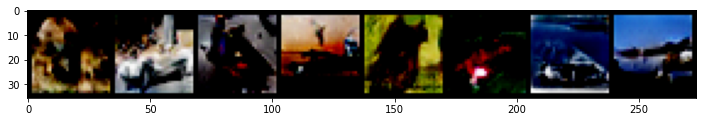

epoch: 141, batch: 100	   lossD: 0.2442(real: 0.1393, fake: 0.1049), lossG: 3.4753,  D(x): 0.8812, D(G(z)): 0.0895, 0.0715
epoch: 141, batch: 200	   lossD: 0.1801(real: 0.0694, fake: 0.1107), lossG: 4.1839,  D(x): 0.9396, D(G(z)): 0.0938, 0.0354
epoch: 141, batch: 300	   lossD: 0.2427(real: 0.1814, fake: 0.0612), lossG: 3.2227,  D(x): 0.8492, D(G(z)): 0.0533, 0.0982
epoch: 141, batch: 400	   lossD: 0.3041(real: 0.1291, fake: 0.1750), lossG: 2.1647,  D(x): 0.8894, D(G(z)): 0.1410, 0.1986
epoch: 141, batch: 500	   lossD: 0.3728(real: 0.2613, fake: 0.1115), lossG: 3.0424,  D(x): 0.7926, D(G(z)): 0.0937, 0.1136
epoch: 141, running_loss_D: 0.3636764883995056, running_loss_G: 3.1401097774505615 

epoch: 142, batch: 100	   lossD: 0.3874(real: 0.0664, fake: 0.3211), lossG: 2.9626,  D(x): 0.9391, D(G(z)): 0.2266, 0.1113
epoch: 142, batch: 200	   lossD: 0.2605(real: 0.1141, fake: 0.1464), lossG: 3.9895,  D(x): 0.8977, D(G(z)): 0.1247, 0.0379
epoch: 142, batch: 300	   lossD: 0.9597(real: 0.0071, 

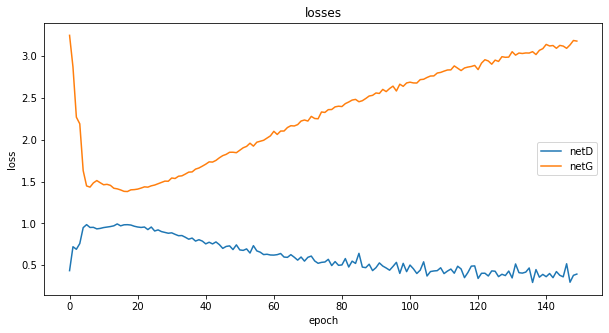

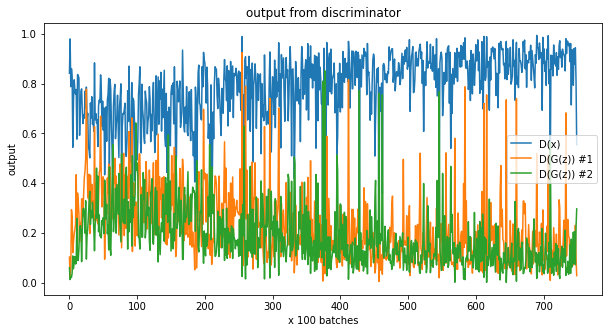

epoch: 151, batch: 100	   lossD: 0.1696(real: 0.0552, fake: 0.1144), lossG: 3.3694,  D(x): 0.9485, D(G(z)): 0.1010, 0.0855
epoch: 151, batch: 200	   lossD: 0.3315(real: 0.2726, fake: 0.0589), lossG: 2.0860,  D(x): 0.7888, D(G(z)): 0.0552, 0.2810
epoch: 151, batch: 300	   lossD: 0.3931(real: 0.2968, fake: 0.0963), lossG: 2.2106,  D(x): 0.7721, D(G(z)): 0.0811, 0.2069
epoch: 151, batch: 400	   lossD: 0.2044(real: 0.0675, fake: 0.1369), lossG: 4.3192,  D(x): 0.9378, D(G(z)): 0.1181, 0.0367
epoch: 151, batch: 500	   lossD: 0.5790(real: 0.5001, fake: 0.0789), lossG: 1.8170,  D(x): 0.6610, D(G(z)): 0.0701, 0.2794
epoch: 151, running_loss_D: 0.384996235370636, running_loss_G: 3.175379514694214 

epoch: 152, batch: 100	   lossD: 0.3005(real: 0.0954, fake: 0.2051), lossG: 3.7509,  D(x): 0.9202, D(G(z)): 0.1541, 0.0495
epoch: 152, batch: 200	   lossD: 0.4625(real: 0.4325, fake: 0.0300), lossG: 2.3342,  D(x): 0.6974, D(G(z)): 0.0279, 0.2136
epoch: 152, batch: 300	   lossD: 0.2991(real: 0.2277, fa

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 160, batch: 500	   lossD: 0.3935(real: 0.0659, fake: 0.3276), lossG: 3.1447,  D(x): 0.9435, D(G(z)): 0.2364, 0.0839
epoch: 160, running_loss_D: 0.43542757630348206, running_loss_G: 3.2462990283966064 



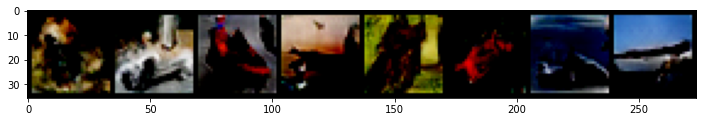

epoch: 161, batch: 100	   lossD: 0.4062(real: 0.0385, fake: 0.3678), lossG: 3.5993,  D(x): 0.9635, D(G(z)): 0.2563, 0.0828
epoch: 161, batch: 200	   lossD: 0.3297(real: 0.0951, fake: 0.2346), lossG: 4.5294,  D(x): 0.9126, D(G(z)): 0.1790, 0.0265
epoch: 161, batch: 300	   lossD: 0.3935(real: 0.1865, fake: 0.2069), lossG: 2.7315,  D(x): 0.8557, D(G(z)): 0.1561, 0.1440
epoch: 161, batch: 400	   lossD: 0.3268(real: 0.2532, fake: 0.0736), lossG: 2.8137,  D(x): 0.7952, D(G(z)): 0.0664, 0.1481
epoch: 161, batch: 500	   lossD: 0.4907(real: 0.0676, fake: 0.4231), lossG: 3.8153,  D(x): 0.9424, D(G(z)): 0.3040, 0.0569
epoch: 161, running_loss_D: 0.32645270228385925, running_loss_G: 3.2162439823150635 

epoch: 162, batch: 100	   lossD: 0.4438(real: 0.0174, fake: 0.4265), lossG: 3.7254,  D(x): 0.9831, D(G(z)): 0.2802, 0.0578
epoch: 162, batch: 200	   lossD: 0.4666(real: 0.0606, fake: 0.4060), lossG: 4.2578,  D(x): 0.9440, D(G(z)): 0.2515, 0.0389
epoch: 162, batch: 300	   lossD: 0.3958(real: 0.0957,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 180, batch: 500	   lossD: 0.3259(real: 0.0842, fake: 0.2416), lossG: 3.6891,  D(x): 0.9245, D(G(z)): 0.1801, 0.0659
epoch: 180, running_loss_D: 0.3631540536880493, running_loss_G: 3.331077814102173 



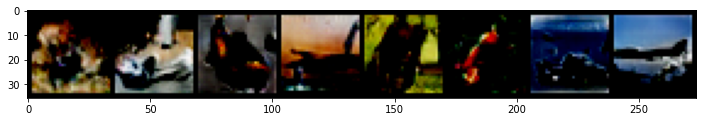

epoch: 181, batch: 100	   lossD: 0.3257(real: 0.1376, fake: 0.1881), lossG: 4.3975,  D(x): 0.8890, D(G(z)): 0.1474, 0.0460
epoch: 181, batch: 200	   lossD: 0.2452(real: 0.1503, fake: 0.0949), lossG: 3.1467,  D(x): 0.8692, D(G(z)): 0.0736, 0.1026
epoch: 181, batch: 300	   lossD: 0.2438(real: 0.1359, fake: 0.1079), lossG: 2.9943,  D(x): 0.8839, D(G(z)): 0.0745, 0.0986
epoch: 181, batch: 400	   lossD: 0.3180(real: 0.2286, fake: 0.0894), lossG: 2.1690,  D(x): 0.8211, D(G(z)): 0.0759, 0.2099
epoch: 181, batch: 500	   lossD: 0.2978(real: 0.2255, fake: 0.0723), lossG: 2.8651,  D(x): 0.8282, D(G(z)): 0.0657, 0.1426
epoch: 181, running_loss_D: 0.4068611264228821, running_loss_G: 3.359609842300415 

epoch: 182, batch: 100	   lossD: 0.1788(real: 0.1226, fake: 0.0562), lossG: 2.3488,  D(x): 0.8959, D(G(z)): 0.0510, 0.1752
epoch: 182, batch: 200	   lossD: 0.2087(real: 0.0942, fake: 0.1145), lossG: 3.1923,  D(x): 0.9185, D(G(z)): 0.0899, 0.0832
epoch: 182, batch: 300	   lossD: 0.2531(real: 0.1930, f

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 200, batch: 500	   lossD: 0.4397(real: 0.0444, fake: 0.3954), lossG: 4.2480,  D(x): 0.9586, D(G(z)): 0.2579, 0.0562
epoch: 200, running_loss_D: 0.38332465291023254, running_loss_G: 3.550046682357788 



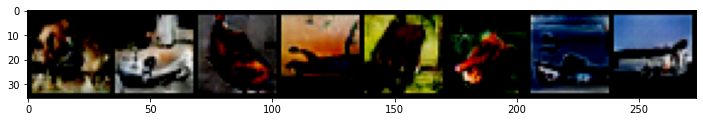

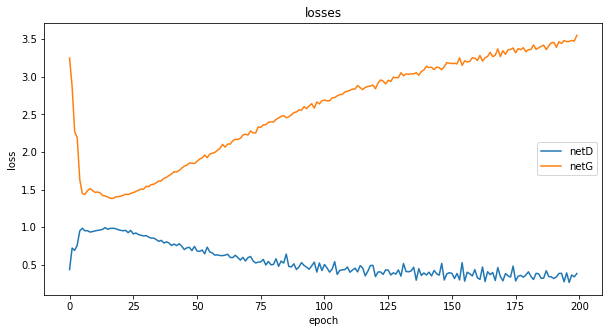

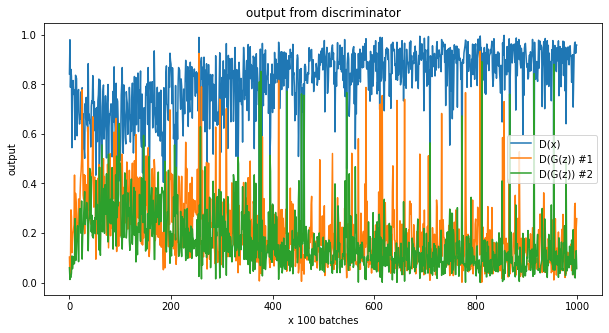

epoch: 201, batch: 100	   lossD: 0.6757(real: 0.6559, fake: 0.0198), lossG: 1.8509,  D(x): 0.5910, D(G(z)): 0.0188, 0.3160
epoch: 201, batch: 200	   lossD: 0.3901(real: 0.1942, fake: 0.1959), lossG: 4.1617,  D(x): 0.8426, D(G(z)): 0.1413, 0.0503
epoch: 201, batch: 300	   lossD: 0.4078(real: 0.2854, fake: 0.1224), lossG: 3.9254,  D(x): 0.7819, D(G(z)): 0.0972, 0.0613
epoch: 201, batch: 400	   lossD: 0.2603(real: 0.1826, fake: 0.0776), lossG: 3.4697,  D(x): 0.8643, D(G(z)): 0.0660, 0.0774
epoch: 201, batch: 500	   lossD: 0.2025(real: 0.1226, fake: 0.0799), lossG: 4.2053,  D(x): 0.8952, D(G(z)): 0.0673, 0.0389
epoch: 201, running_loss_D: 0.26142677664756775, running_loss_G: 3.466708183288574 

epoch: 202, batch: 100	   lossD: 0.3073(real: 0.0752, fake: 0.2321), lossG: 4.5459,  D(x): 0.9314, D(G(z)): 0.1775, 0.0277
epoch: 202, batch: 200	   lossD: 0.1321(real: 0.1010, fake: 0.0311), lossG: 4.5277,  D(x): 0.9116, D(G(z)): 0.0299, 0.0479
epoch: 202, batch: 300	   lossD: 0.0874(real: 0.0625, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 220, batch: 500	   lossD: 0.6582(real: 0.0037, fake: 0.6546), lossG: 5.3426,  D(x): 0.9964, D(G(z)): 0.3848, 0.0256
epoch: 220, running_loss_D: 0.27414652705192566, running_loss_G: 3.6109817028045654 



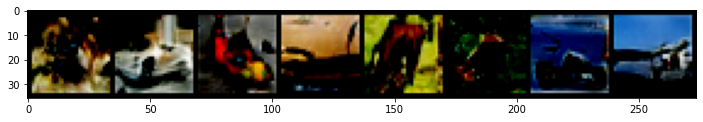

epoch: 221, batch: 100	   lossD: 0.2848(real: 0.1938, fake: 0.0910), lossG: 2.0346,  D(x): 0.8501, D(G(z)): 0.0784, 0.2211
epoch: 221, batch: 200	   lossD: 0.1657(real: 0.0636, fake: 0.1021), lossG: 4.6233,  D(x): 0.9407, D(G(z)): 0.0856, 0.0339
epoch: 221, batch: 300	   lossD: 0.2394(real: 0.0912, fake: 0.1482), lossG: 3.9485,  D(x): 0.9203, D(G(z)): 0.1049, 0.0502
epoch: 221, batch: 400	   lossD: 0.1719(real: 0.0527, fake: 0.1192), lossG: 4.5292,  D(x): 0.9522, D(G(z)): 0.1017, 0.0360
epoch: 221, batch: 500	   lossD: 0.2928(real: 0.2304, fake: 0.0624), lossG: 2.7105,  D(x): 0.8176, D(G(z)): 0.0516, 0.1773
epoch: 221, running_loss_D: 0.3663511872291565, running_loss_G: 3.6499431133270264 

epoch: 222, batch: 100	   lossD: 0.1778(real: 0.0906, fake: 0.0872), lossG: 4.1414,  D(x): 0.9188, D(G(z)): 0.0772, 0.0470
epoch: 222, batch: 200	   lossD: 0.2739(real: 0.2077, fake: 0.0661), lossG: 3.3181,  D(x): 0.8283, D(G(z)): 0.0552, 0.1018
epoch: 222, batch: 300	   lossD: 0.3512(real: 0.2762, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 240, batch: 500	   lossD: 0.2370(real: 0.1966, fake: 0.0404), lossG: 4.2413,  D(x): 0.8508, D(G(z)): 0.0365, 0.0552
epoch: 240, running_loss_D: 0.2660731077194214, running_loss_G: 3.803070306777954 



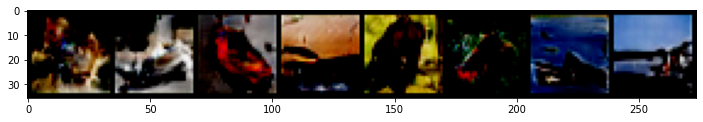

epoch: 241, batch: 100	   lossD: 5.4242(real: 0.0002, fake: 5.4240), lossG: 9.5096,  D(x): 0.9998, D(G(z)): 0.9487, 0.0025
epoch: 241, batch: 200	   lossD: 0.3930(real: 0.2987, fake: 0.0943), lossG: 2.6095,  D(x): 0.7806, D(G(z)): 0.0762, 0.1604
epoch: 241, batch: 300	   lossD: 0.3563(real: 0.3071, fake: 0.0492), lossG: 4.1849,  D(x): 0.7744, D(G(z)): 0.0433, 0.0479
epoch: 241, batch: 400	   lossD: 0.1254(real: 0.0440, fake: 0.0814), lossG: 3.3166,  D(x): 0.9600, D(G(z)): 0.0724, 0.1021
epoch: 241, batch: 500	   lossD: 0.2663(real: 0.0363, fake: 0.2299), lossG: 3.3391,  D(x): 0.9654, D(G(z)): 0.1588, 0.1115
epoch: 241, running_loss_D: 0.3589927852153778, running_loss_G: 3.7779781818389893 

epoch: 242, batch: 100	   lossD: 0.4677(real: 0.4191, fake: 0.0487), lossG: 1.7617,  D(x): 0.7086, D(G(z)): 0.0405, 0.3156
epoch: 242, batch: 200	   lossD: 0.2161(real: 0.1325, fake: 0.0837), lossG: 3.8968,  D(x): 0.8890, D(G(z)): 0.0742, 0.0730
epoch: 242, batch: 300	   lossD: 0.2164(real: 0.1329, 

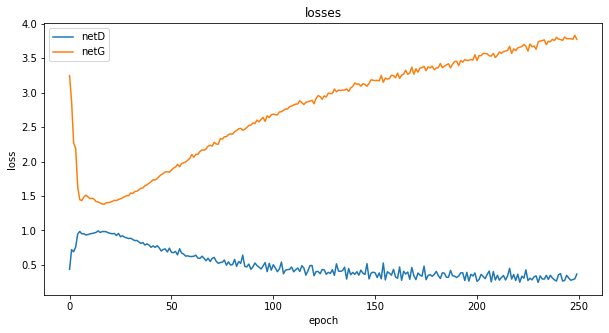

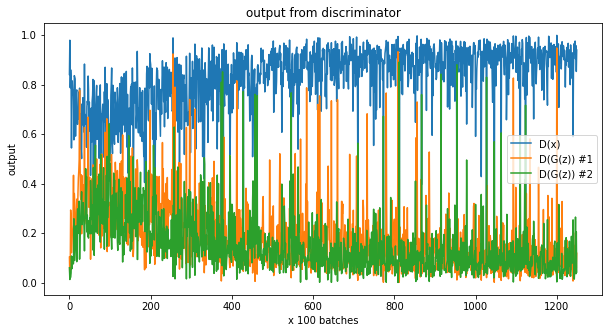

epoch: 251, batch: 100	   lossD: 0.3185(real: 0.0772, fake: 0.2413), lossG: 4.6725,  D(x): 0.9312, D(G(z)): 0.1606, 0.0323
epoch: 251, batch: 200	   lossD: 0.3861(real: 0.3444, fake: 0.0417), lossG: 2.8073,  D(x): 0.7483, D(G(z)): 0.0327, 0.1664
epoch: 251, batch: 300	   lossD: 0.2974(real: 0.2381, fake: 0.0593), lossG: 2.7358,  D(x): 0.8213, D(G(z)): 0.0532, 0.1864
epoch: 251, batch: 400	   lossD: 0.1321(real: 0.1019, fake: 0.0302), lossG: 3.8811,  D(x): 0.9113, D(G(z)): 0.0278, 0.0608
epoch: 251, batch: 500	   lossD: 0.1659(real: 0.0416, fake: 0.1242), lossG: 3.5331,  D(x): 0.9613, D(G(z)): 0.0962, 0.0926
epoch: 251, running_loss_D: 0.2550507187843323, running_loss_G: 3.8284027576446533 

epoch: 252, batch: 100	   lossD: 0.2048(real: 0.0757, fake: 0.1291), lossG: 4.2056,  D(x): 0.9342, D(G(z)): 0.1062, 0.0622
epoch: 252, batch: 200	   lossD: 0.1437(real: 0.1194, fake: 0.0244), lossG: 5.2463,  D(x): 0.8945, D(G(z)): 0.0233, 0.0267
epoch: 252, batch: 300	   lossD: 0.6434(real: 0.0301, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 260, batch: 500	   lossD: 0.2747(real: 0.0377, fake: 0.2369), lossG: 4.5576,  D(x): 0.9672, D(G(z)): 0.1749, 0.0540
epoch: 260, running_loss_D: 0.2682523727416992, running_loss_G: 3.7929131984710693 



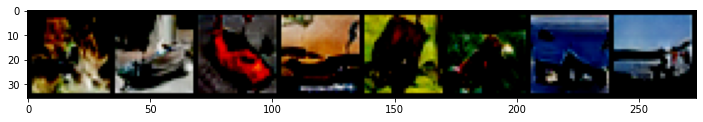

epoch: 261, batch: 100	   lossD: 0.2475(real: 0.1798, fake: 0.0677), lossG: 2.7108,  D(x): 0.8574, D(G(z)): 0.0588, 0.1651
epoch: 261, batch: 200	   lossD: 0.3322(real: 0.0051, fake: 0.3270), lossG: 3.8009,  D(x): 0.9949, D(G(z)): 0.2378, 0.0697
epoch: 261, batch: 300	   lossD: 3.9464(real: 1.8947, fake: 2.0516), lossG: 3.1145,  D(x): 0.3952, D(G(z)): 0.2629, 0.5029
epoch: 261, batch: 400	   lossD: 0.3674(real: 0.2808, fake: 0.0867), lossG: 3.8080,  D(x): 0.8076, D(G(z)): 0.0606, 0.0799
epoch: 261, batch: 500	   lossD: 0.2894(real: 0.0724, fake: 0.2169), lossG: 2.7486,  D(x): 0.9399, D(G(z)): 0.1634, 0.1618
epoch: 261, running_loss_D: 0.53151935338974, running_loss_G: 3.8484485149383545 

epoch: 262, batch: 100	   lossD: 0.2358(real: 0.0386, fake: 0.1972), lossG: 4.7413,  D(x): 0.9636, D(G(z)): 0.1333, 0.0405
epoch: 262, batch: 200	   lossD: 0.3757(real: 0.1078, fake: 0.2679), lossG: 4.0579,  D(x): 0.9088, D(G(z)): 0.1742, 0.0734
epoch: 262, batch: 300	   lossD: 0.2853(real: 0.2231, fa

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 280, batch: 500	   lossD: 0.2206(real: 0.0828, fake: 0.1378), lossG: 3.2793,  D(x): 0.9288, D(G(z)): 0.1093, 0.1013
epoch: 280, running_loss_D: 0.2864918112754822, running_loss_G: 3.9332711696624756 



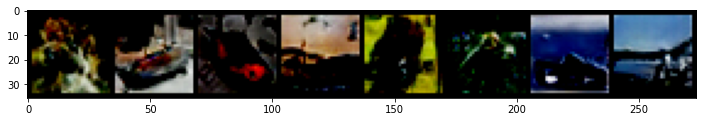

epoch: 281, batch: 100	   lossD: 0.1615(real: 0.0927, fake: 0.0688), lossG: 4.6632,  D(x): 0.9198, D(G(z)): 0.0491, 0.0331
epoch: 281, batch: 200	   lossD: 0.1963(real: 0.1248, fake: 0.0715), lossG: 3.0381,  D(x): 0.8930, D(G(z)): 0.0623, 0.1176
epoch: 281, batch: 300	   lossD: 0.2583(real: 0.2228, fake: 0.0355), lossG: 4.1250,  D(x): 0.8224, D(G(z)): 0.0324, 0.0686
epoch: 281, batch: 400	   lossD: 0.3835(real: 0.3028, fake: 0.0807), lossG: 3.4095,  D(x): 0.7709, D(G(z)): 0.0634, 0.0994
epoch: 281, batch: 500	   lossD: 0.1750(real: 0.0729, fake: 0.1021), lossG: 4.1961,  D(x): 0.9341, D(G(z)): 0.0807, 0.0436
epoch: 281, running_loss_D: 0.30326756834983826, running_loss_G: 3.8679721355438232 

epoch: 282, batch: 100	   lossD: 0.3158(real: 0.0353, fake: 0.2805), lossG: 5.3413,  D(x): 0.9665, D(G(z)): 0.1959, 0.0232
epoch: 282, batch: 200	   lossD: 0.1958(real: 0.1839, fake: 0.0120), lossG: 4.5927,  D(x): 0.8599, D(G(z)): 0.0116, 0.0541
epoch: 282, batch: 300	   lossD: 0.2294(real: 0.1713,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 300, batch: 500	   lossD: 0.1489(real: 0.0945, fake: 0.0543), lossG: 2.7648,  D(x): 0.9162, D(G(z)): 0.0426, 0.1678
epoch: 300, running_loss_D: 0.24474981427192688, running_loss_G: 3.9594852924346924 



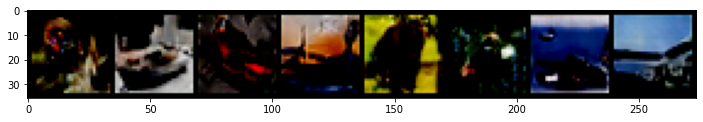

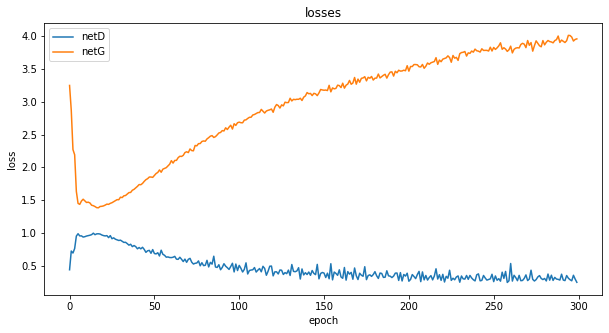

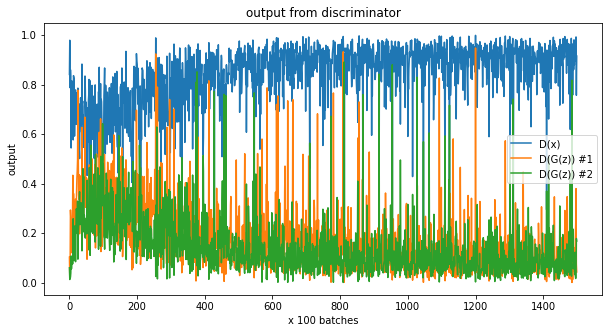

epoch: 301, batch: 100	   lossD: 0.5995(real: 0.0089, fake: 0.5907), lossG: 4.1667,  D(x): 0.9916, D(G(z)): 0.3284, 0.0659
epoch: 301, batch: 200	   lossD: 0.4145(real: 0.2338, fake: 0.1807), lossG: 3.1582,  D(x): 0.8565, D(G(z)): 0.1328, 0.1187
epoch: 301, batch: 300	   lossD: 0.2063(real: 0.0153, fake: 0.1910), lossG: 2.9040,  D(x): 0.9851, D(G(z)): 0.1358, 0.1640
epoch: 301, batch: 400	   lossD: 0.1790(real: 0.0578, fake: 0.1212), lossG: 4.1134,  D(x): 0.9486, D(G(z)): 0.0955, 0.0548
epoch: 301, batch: 500	   lossD: 0.1537(real: 0.0899, fake: 0.0638), lossG: 3.9518,  D(x): 0.9262, D(G(z)): 0.0531, 0.0724
epoch: 301, running_loss_D: 0.3698144257068634, running_loss_G: 3.9229207038879395 

epoch: 302, batch: 100	   lossD: 0.1509(real: 0.1141, fake: 0.0368), lossG: 4.1346,  D(x): 0.9085, D(G(z)): 0.0329, 0.0540
epoch: 302, batch: 200	   lossD: 0.1995(real: 0.1637, fake: 0.0358), lossG: 3.4588,  D(x): 0.8797, D(G(z)): 0.0337, 0.1115
epoch: 302, batch: 300	   lossD: 0.2440(real: 0.2321, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 320, batch: 500	   lossD: 0.0961(real: 0.0301, fake: 0.0660), lossG: 5.3422,  D(x): 0.9718, D(G(z)): 0.0542, 0.0184
epoch: 320, running_loss_D: 0.24609172344207764, running_loss_G: 4.098796367645264 



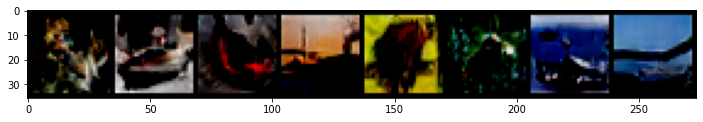

epoch: 321, batch: 100	   lossD: 0.2108(real: 0.1824, fake: 0.0284), lossG: 3.3347,  D(x): 0.8513, D(G(z)): 0.0262, 0.1445
epoch: 321, batch: 200	   lossD: 0.2443(real: 0.1423, fake: 0.1020), lossG: 4.2704,  D(x): 0.8835, D(G(z)): 0.0623, 0.0756
epoch: 321, batch: 300	   lossD: 0.2765(real: 0.1757, fake: 0.1008), lossG: 3.4083,  D(x): 0.8635, D(G(z)): 0.0763, 0.1354
epoch: 321, batch: 400	   lossD: 0.5952(real: 0.0261, fake: 0.5691), lossG: 4.3794,  D(x): 0.9761, D(G(z)): 0.3236, 0.0759
epoch: 321, batch: 500	   lossD: 0.2657(real: 0.1896, fake: 0.0761), lossG: 3.2150,  D(x): 0.8662, D(G(z)): 0.0691, 0.1294
epoch: 321, running_loss_D: 0.378406286239624, running_loss_G: 4.131981372833252 

epoch: 322, batch: 100	   lossD: 0.1350(real: 0.0754, fake: 0.0596), lossG: 4.4393,  D(x): 0.9333, D(G(z)): 0.0473, 0.0429
epoch: 322, batch: 200	   lossD: 0.2285(real: 0.0229, fake: 0.2056), lossG: 5.4659,  D(x): 0.9784, D(G(z)): 0.1578, 0.0245
epoch: 322, batch: 300	   lossD: 0.2533(real: 0.0520, fa

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 340, batch: 500	   lossD: 0.2231(real: 0.0964, fake: 0.1267), lossG: 4.5317,  D(x): 0.9149, D(G(z)): 0.0988, 0.0365
epoch: 340, running_loss_D: 0.3688710927963257, running_loss_G: 4.192714691162109 



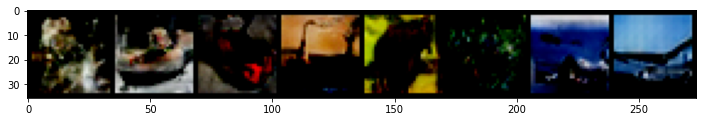

epoch: 341, batch: 100	   lossD: 0.1729(real: 0.0578, fake: 0.1151), lossG: 4.8567,  D(x): 0.9464, D(G(z)): 0.0849, 0.0382
epoch: 341, batch: 200	   lossD: 0.2773(real: 0.0375, fake: 0.2398), lossG: 5.2188,  D(x): 0.9647, D(G(z)): 0.1438, 0.0372
epoch: 341, batch: 300	   lossD: 0.1722(real: 0.1367, fake: 0.0355), lossG: 4.3236,  D(x): 0.8841, D(G(z)): 0.0329, 0.0547
epoch: 341, batch: 400	   lossD: 0.1654(real: 0.1413, fake: 0.0241), lossG: 1.9580,  D(x): 0.8898, D(G(z)): 0.0234, 0.3175
epoch: 341, batch: 500	   lossD: 0.3120(real: 0.2536, fake: 0.0585), lossG: 3.9118,  D(x): 0.8075, D(G(z)): 0.0490, 0.0794
epoch: 341, running_loss_D: 0.28530120849609375, running_loss_G: 4.178092956542969 

epoch: 342, batch: 100	   lossD: 0.1978(real: 0.0705, fake: 0.1273), lossG: 3.5873,  D(x): 0.9384, D(G(z)): 0.0988, 0.0897
epoch: 342, batch: 200	   lossD: 0.0655(real: 0.0272, fake: 0.0382), lossG: 4.3217,  D(x): 0.9780, D(G(z)): 0.0357, 0.0504
epoch: 342, batch: 300	   lossD: 0.3088(real: 0.2668, 

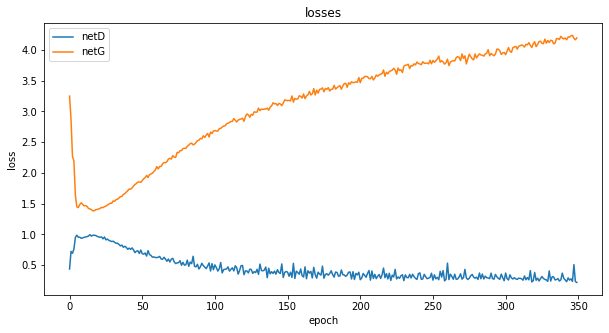

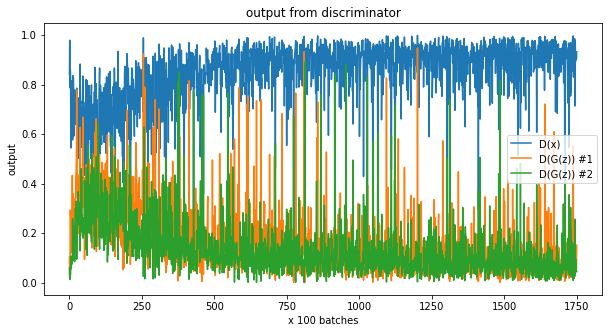

epoch: 351, batch: 100	   lossD: 0.2297(real: 0.1083, fake: 0.1214), lossG: 3.8062,  D(x): 0.9127, D(G(z)): 0.0933, 0.0932
epoch: 351, batch: 200	   lossD: 0.2654(real: 0.0064, fake: 0.2590), lossG: 3.8756,  D(x): 0.9937, D(G(z)): 0.1738, 0.0949
epoch: 351, batch: 300	   lossD: 0.2349(real: 0.1818, fake: 0.0531), lossG: 3.5774,  D(x): 0.8599, D(G(z)): 0.0458, 0.1009
epoch: 351, batch: 400	   lossD: 0.1404(real: 0.0696, fake: 0.0708), lossG: 3.7642,  D(x): 0.9412, D(G(z)): 0.0558, 0.1140
epoch: 351, batch: 500	   lossD: 0.2411(real: 0.0260, fake: 0.2152), lossG: 4.9148,  D(x): 0.9752, D(G(z)): 0.1423, 0.0283
epoch: 351, running_loss_D: 0.3000987768173218, running_loss_G: 4.190959930419922 

epoch: 352, batch: 100	   lossD: 0.5543(real: 0.0271, fake: 0.5272), lossG: 6.7590,  D(x): 0.9793, D(G(z)): 0.3060, 0.0083
epoch: 352, batch: 200	   lossD: 0.3891(real: 0.1538, fake: 0.2353), lossG: 5.5894,  D(x): 0.8852, D(G(z)): 0.1736, 0.0316
epoch: 352, batch: 300	   lossD: 0.0603(real: 0.0247, f

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 360, batch: 500	   lossD: 0.2398(real: 0.2128, fake: 0.0270), lossG: 3.5107,  D(x): 0.8362, D(G(z)): 0.0251, 0.1343
epoch: 360, running_loss_D: 0.22843338549137115, running_loss_G: 4.29711389541626 



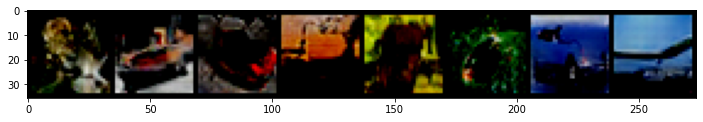

epoch: 361, batch: 100	   lossD: 0.4183(real: 0.0997, fake: 0.3186), lossG: 6.7218,  D(x): 0.9161, D(G(z)): 0.1997, 0.0091
epoch: 361, batch: 200	   lossD: 0.1846(real: 0.0742, fake: 0.1104), lossG: 4.4204,  D(x): 0.9375, D(G(z)): 0.0863, 0.0619
epoch: 361, batch: 300	   lossD: 0.1208(real: 0.0778, fake: 0.0430), lossG: 4.0785,  D(x): 0.9306, D(G(z)): 0.0397, 0.0644
epoch: 361, batch: 400	   lossD: 0.2213(real: 0.1361, fake: 0.0852), lossG: 4.4578,  D(x): 0.8929, D(G(z)): 0.0685, 0.0532
epoch: 361, batch: 500	   lossD: 0.3851(real: 0.1258, fake: 0.2593), lossG: 5.0059,  D(x): 0.9000, D(G(z)): 0.1709, 0.0298
epoch: 361, running_loss_D: 0.36883431673049927, running_loss_G: 4.168748378753662 

epoch: 362, batch: 100	   lossD: 0.6536(real: 0.6420, fake: 0.0116), lossG: 3.7401,  D(x): 0.6166, D(G(z)): 0.0113, 0.1021
epoch: 362, batch: 200	   lossD: 0.2629(real: 0.1445, fake: 0.1184), lossG: 4.3599,  D(x): 0.8829, D(G(z)): 0.0941, 0.0539
epoch: 362, batch: 300	   lossD: 0.2514(real: 0.2150, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 380, batch: 500	   lossD: 0.2110(real: 0.0194, fake: 0.1916), lossG: 4.7376,  D(x): 0.9814, D(G(z)): 0.1231, 0.0361
epoch: 380, running_loss_D: 0.2154783308506012, running_loss_G: 4.394845008850098 



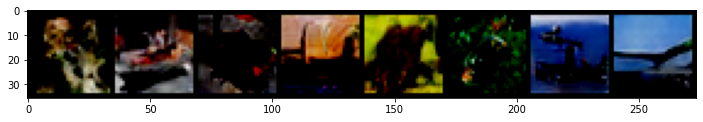

epoch: 381, batch: 100	   lossD: 0.2050(real: 0.0401, fake: 0.1650), lossG: 5.5644,  D(x): 0.9630, D(G(z)): 0.1136, 0.0129
epoch: 381, batch: 200	   lossD: 0.1648(real: 0.0287, fake: 0.1361), lossG: 3.8745,  D(x): 0.9736, D(G(z)): 0.1080, 0.0857
epoch: 381, batch: 300	   lossD: 0.2274(real: 0.0653, fake: 0.1621), lossG: 4.5163,  D(x): 0.9432, D(G(z)): 0.1116, 0.0493
epoch: 381, batch: 400	   lossD: 1.8717(real: 1.8507, fake: 0.0210), lossG: 1.0407,  D(x): 0.3660, D(G(z)): 0.0182, 0.5650
epoch: 381, batch: 500	   lossD: 0.1622(real: 0.1046, fake: 0.0576), lossG: 4.8670,  D(x): 0.9235, D(G(z)): 0.0467, 0.0417
epoch: 381, running_loss_D: 0.2856779098510742, running_loss_G: 4.3585124015808105 

epoch: 382, batch: 100	   lossD: 0.1757(real: 0.0506, fake: 0.1251), lossG: 4.5584,  D(x): 0.9524, D(G(z)): 0.0972, 0.0637
epoch: 382, batch: 200	   lossD: 0.1224(real: 0.0508, fake: 0.0715), lossG: 2.1574,  D(x): 0.9591, D(G(z)): 0.0599, 0.2912
epoch: 382, batch: 300	   lossD: 0.3769(real: 0.3143, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 400, batch: 500	   lossD: 0.0835(real: 0.0313, fake: 0.0522), lossG: 5.4319,  D(x): 0.9713, D(G(z)): 0.0457, 0.0316
epoch: 400, running_loss_D: 0.3354645371437073, running_loss_G: 4.516161918640137 



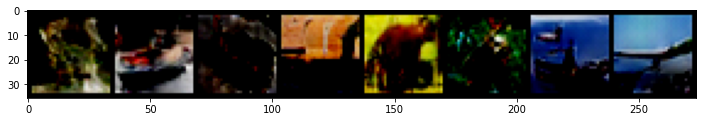

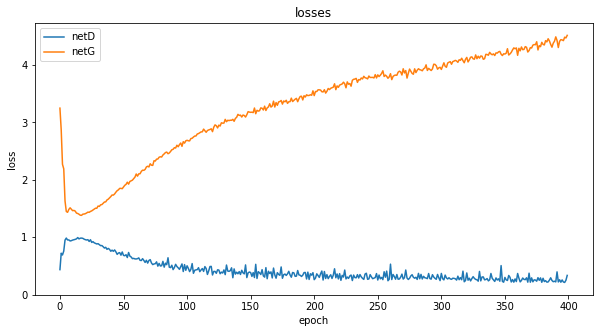

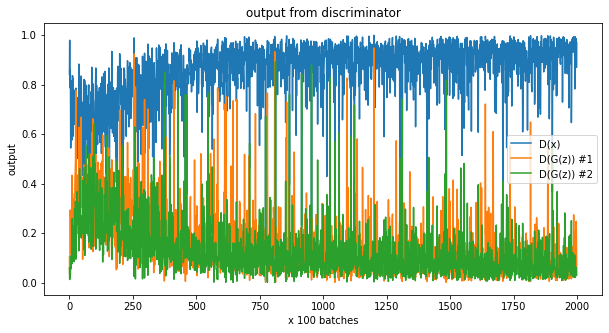

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


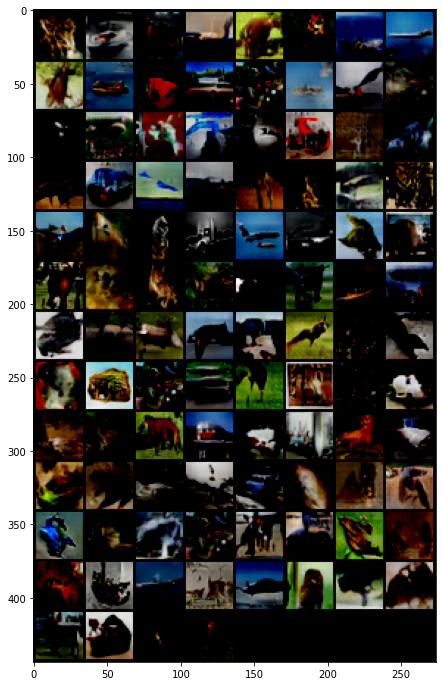

In [13]:
EPOCHS = 400 #学習の回数を変更してどれだけ綺麗になるかを出してみよう
losses, outs, nets= train(netD, netG, batch_size, zsize, EPOCHS, trainloader)

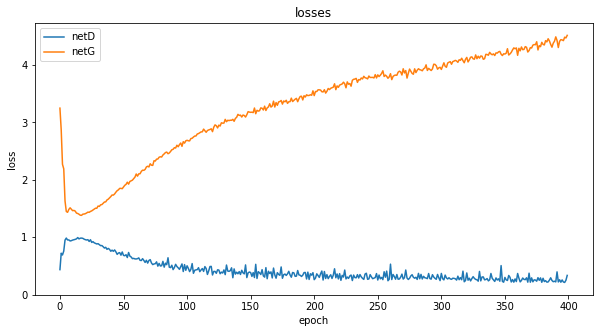

In [14]:
plt.figure(figsize=(10,5))
plt.title('losses')
plt.plot(losses[0], label='netD')
plt.plot(losses[1], label='netG')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('1821035_losses.jpg')
plt.show()

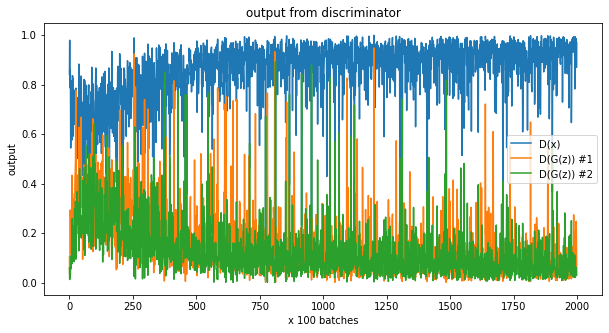

In [15]:
plt.figure(figsize=(10,5))
plt.title('output from discriminator')
plt.plot(outs[0], label='D(x)')
plt.plot(outs[1], label='D(G(z)) #1')
plt.plot(outs[2], label='D(G(z)) #2')
plt.xlabel('x 100 batches')
plt.ylabel('output')
plt.legend()
plt.savefig('1821035_output.jpg')
plt.show()

# 宿題




## 【1】綺麗な画像を生成して１番良さそうなのを提出してください
この事例研究の時間だけまわしておしまいなのは勿体ないです。なのでぜひ皆さんの自身の手を動かしてどのように結果が変化するのか確認しましょう！

生成した画像とlossの画像を下記のディレクトリへ金曜日までにアップロードしといてください。\
**＜提出場所＞**
```bash:
共有ドライブ/IPL Drive/05_講義資料/事例研究2020/08_20201208/課題提出箱/gxxxxxx
```
gxxxxxxには自分の学籍番号です。既に作成してあるので、そこにアップロードしてください。




## 【2】今日の話で大切だと思ったプログラムにコメントを入れる
　コメントは**ソースコードの保守をする人に情報を伝えるため**に記述します。なお、この保守する人には未来の自分も含まれます。

　いくら自分が書いたソースコードとはいえ、半年も経てば細かい仕様等は忘れていきます。なので、未来の自分や他の人がこのソースを使いたいとき、コメントがあることによって彼らの作業時間の短縮ができます。今回はその練習としてコメント入れる作業の練習をしましょう。


コメントとして記述するもの
- 実装概念との対応関係
    - 今回であれば、`GANのGeneratorはこの部分で定義されている`等
- 引数の説明
    - 特に直打ちしている値は、**その値が何なのか**がわかるようなコメントを記述しましょう

最初のセル2つは佐藤がコメントアウトで入れています。\
伝わるように書けばいいのでコメントの書き方は自由なので工夫してください。



# 変更点
#### バッチノーマライゼーションを追記
- 学習効率の向上、過学習の抑制、初期値に対しての依存度を低下させるため。

#### 重みを独自に初期化
- 初期値はニューラルネットワークの学習速度に影響を及ぼす。さらに、適切な初期値を設定しないと「勾配消失」、「表現力の制限」といった問題も引き起こす。
今回は、平均0、標準偏差0.02に設定した。
  

In [16]:
!free -h 

              total        used        free      shared  buff/cache   available
Mem:            12G         11G        188M         12M        1.3G        8.1G
Swap:            0B          0B          0B


In [17]:
!nvidia-smi

Mon Dec 14 20:35:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    34W /  70W |   1417MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------